* ##### Entity-Level X Sentiment Analysis for Brand Perception
* ##### Name: Barath Anandaraman
* ##### Date: 06/19/2025

#### Load necessary packages

In [1]:
import zipfile
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#### Load training and validation dataset

In [2]:
zip_path = "data/twitter_training.csv.zip"
extract_dir = "data/"
with zipfile.ZipFile(zip_path,'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [3]:
train_df = pd.read_csv(os.path.join(extract_dir,"twitter_training.csv"), header=None, names=["tweetId", "entity", "sentiment", "tweet"])
validation_df = pd.read_csv(os.path.join(extract_dir,"twitter_validation.csv"), header=None, names=["tweetId", "entity", "sentiment", "tweet"])

In [4]:
# Check dataframe data
train_df.head(2), validation_df.head(2)

(   tweetId       entity sentiment  \
 0     2401  Borderlands  Positive   
 1     2401  Borderlands  Positive   
 
                                                tweet  
 0  im getting on borderlands and i will murder yo...  
 1  I am coming to the borders and I will kill you...  ,
    tweetId    entity   sentiment  \
 0     3364  Facebook  Irrelevant   
 1      352    Amazon     Neutral   
 
                                                tweet  
 0  I mentioned on Facebook that I was struggling ...  
 1  BBC News - Amazon boss Jeff Bezos rejects clai...  )

In [5]:
# Check if any null is present on dataframe
print(train_df.isnull().any())
print(validation_df.isnull().any())

tweetId      False
entity       False
sentiment    False
tweet         True
dtype: bool
tweetId      False
entity       False
sentiment    False
tweet        False
dtype: bool


In [6]:
# Remove rows where tweet is having null on train_df
train_df.dropna(subset=['tweet'], inplace=True)

#### Perform EDA

In [7]:
sentiment_counts = train_df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment','Count']

In [8]:
entity_counts = train_df['entity'].value_counts().reset_index()
entity_counts.columns = ['entity','Count']

#### Tweet length distribution

In [9]:
train_df["tweet_length"] = train_df["tweet"].apply(lambda x: len (x.split()))
length_dist = train_df["tweet_length"].describe()

#### Plotting

In [10]:
plt.style.use('ggplot')
sns.set(style='whitegrid')

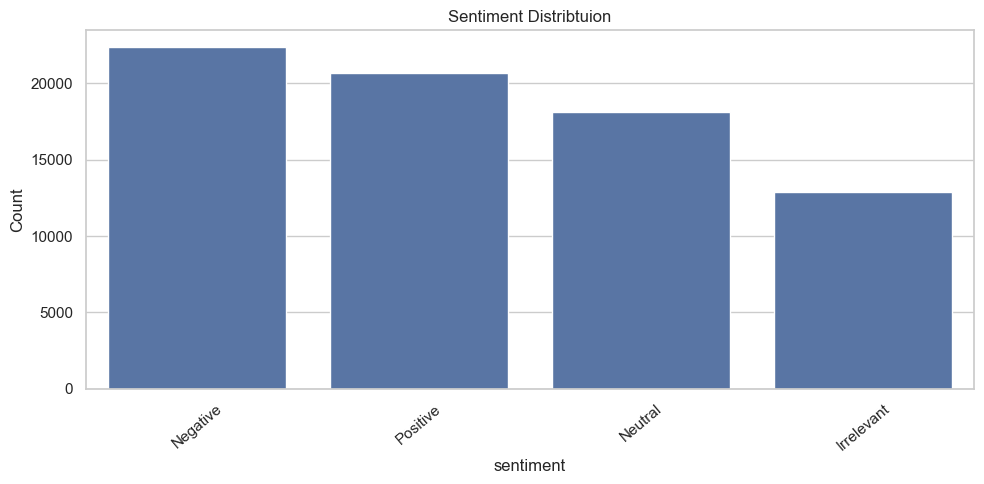

In [11]:
plt.figure(figsize=(10,5))
sns.barplot(data = sentiment_counts, x='sentiment', y='Count')
plt.title("Sentiment Distribtuion")
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()

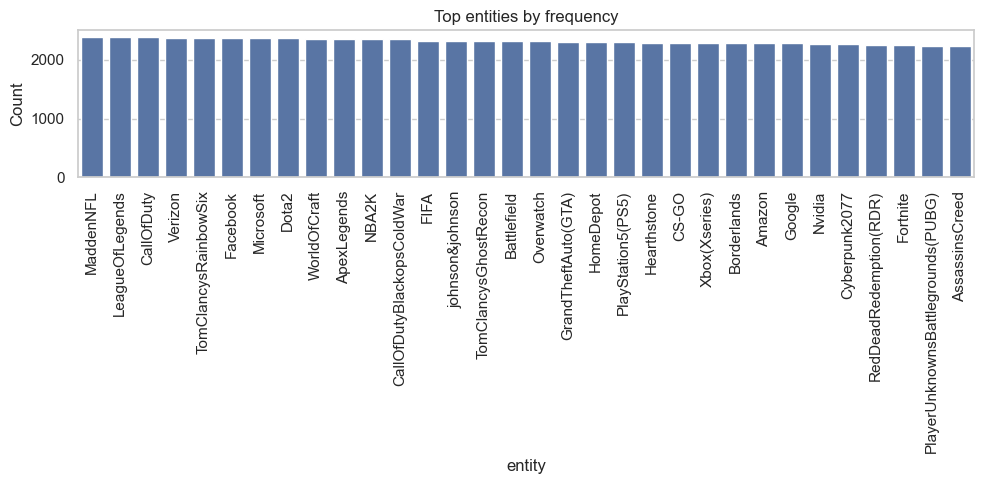

In [12]:
plt.figure(figsize=(10,5))
sns.barplot(data = entity_counts, x='entity', y='Count')
plt.title("Top entities by frequency")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

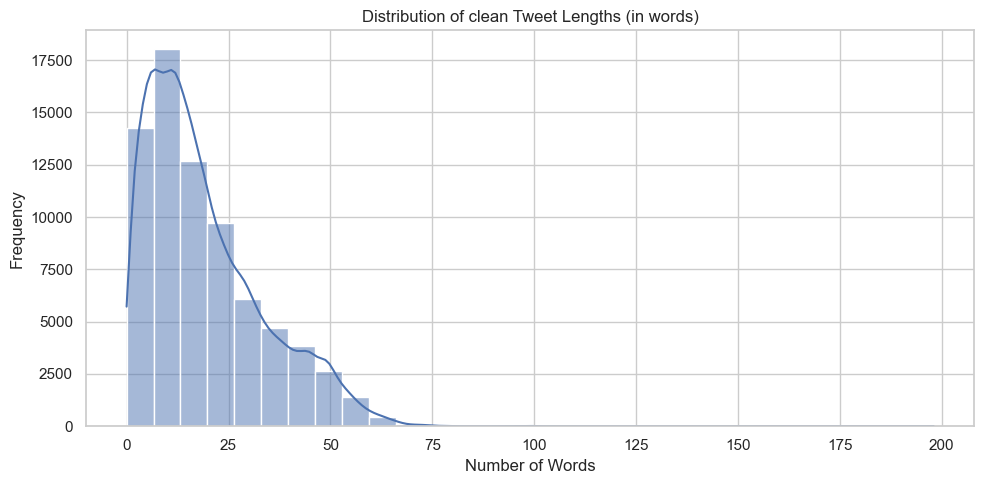

In [13]:
plt.figure(figsize=(10,5))
sns.histplot(train_df["tweet_length"], bins=30, kde=True)
plt.title("Distribution of clean Tweet Lengths (in words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#### Text cleaning and preprocessing

In [14]:
# Function to clean text
def clean_text(text):
    """
    Clean and preprocess the text data with default logic   
    Args:
        text (str): Input text      
    Returns:
        str: Cleaned text
    """
    if pd.isna(text):
        return ""
        
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|@\S+|#\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove punctuation, numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [15]:
# Function to tokenize, stop word removal and lemmatize
def preprocess_text(text):
    """
    Function to clean, tokenize, remove stopwords, and lemmatize.
    Args:
        text (str): Input text
        
    Returns:
        str: Preprocessed text
    """
        
    # Clean text
    text = clean_text(text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into text
    processed_text = ' '.join(tokens)
    
    return processed_text

In [16]:
# Download nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/banandaraman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/banandaraman/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/banandaraman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/banandaraman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
print("Preprocessing training data, please wait a few minutes...")
train_df['processed_text'] = train_df['tweet'].apply(preprocess_text)
print("Processed training data.")
print("Preprocessing test data, please wait a few minutes...")
validation_df['processed_text'] = validation_df['tweet'].apply(preprocess_text)
print("Processed testing data.")

Preprocessing training data, please wait a few minutes...
Processed training data.
Preprocessing test data, please wait a few minutes...
Processed testing data.


#### Get the train, test dataset

In [18]:
X_train = train_df['processed_text']
y_train = train_df['sentiment']

X_test = validation_df['processed_text']
y_test = validation_df['sentiment']

#### TF-IDF vectorization

In [19]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#### Logistic Regression

In [20]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

#### Predictions and evaluation

In [21]:
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Irrelevant       0.77      0.74      0.76       172
    Negative       0.78      0.86      0.82       266
     Neutral       0.87      0.73      0.79       285
    Positive       0.79      0.86      0.83       277

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.81      0.80      0.80      1000



#### Confusion matrix

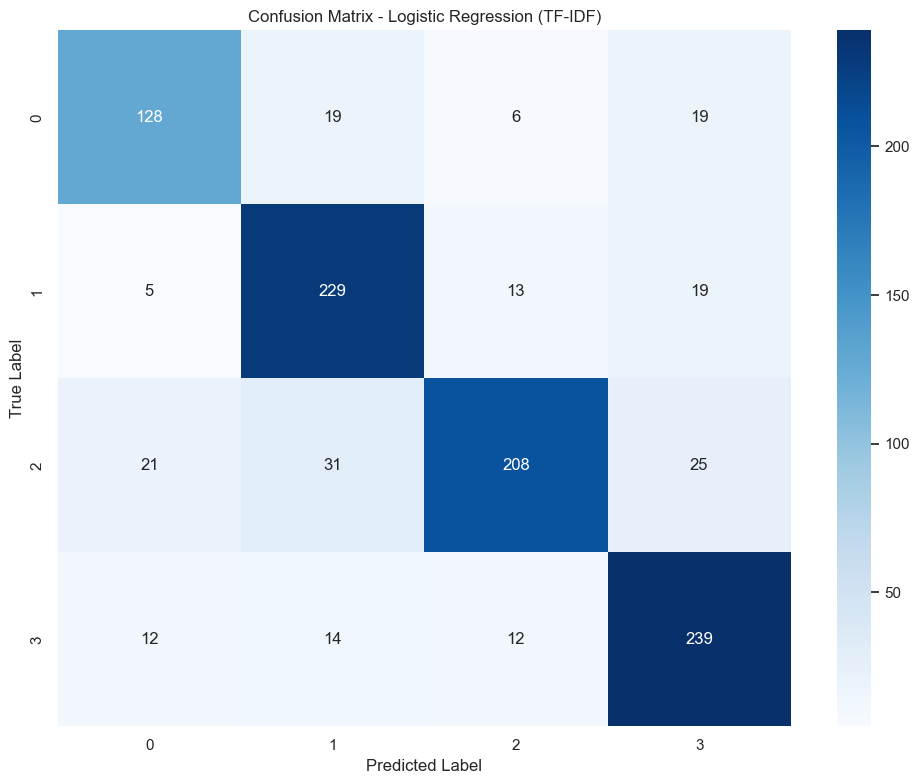

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
           )
plt.title("Confusion Matrix - Logistic Regression (TF-IDF)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

#### Random Forest

In [23]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_depth=25, random_state=42)

#### Prediction and Evaluation

In [26]:
y_pred_rf = rf_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

  Irrelevant       1.00      0.10      0.19       172
    Negative       0.44      0.94      0.60       266
     Neutral       0.87      0.41      0.56       285
    Positive       0.68      0.68      0.68       277

    accuracy                           0.57      1000
   macro avg       0.75      0.53      0.51      1000
weighted avg       0.73      0.57      0.54      1000



#### Confusion matrix

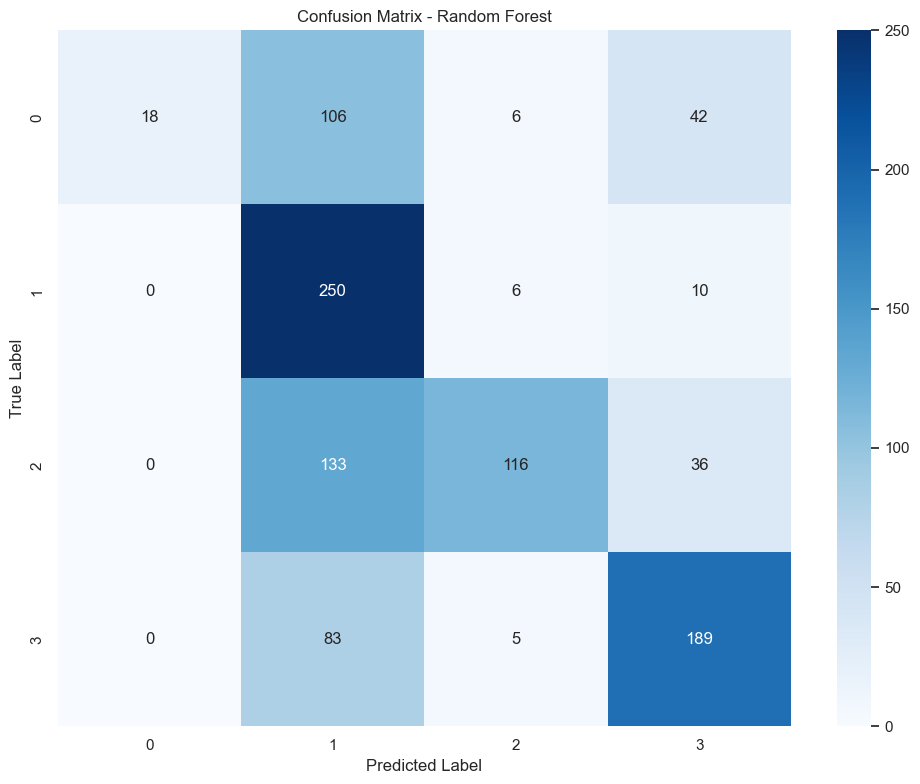

In [27]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10,8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap="Blues",
           )
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()